In [4]:
!conda env list

# conda environments:
#
base                  *  /opt/conda



In [3]:
import sys
print(sys.executable)
print(sys.path)


/opt/conda/bin/python
['/home/jovyan/work/Documents/big_earth_springboard_project/data_science', '/opt/conda/lib/python37.zip', '/opt/conda/lib/python3.7', '/opt/conda/lib/python3.7/lib-dynload', '', '/opt/conda/lib/python3.7/site-packages', '/opt/conda/lib/python3.7/site-packages/IPython/extensions', '/home/jovyan/.ipython']


In [1]:
import datetime
import os
from collections import defaultdict
import gc
from joblib import dump, load
import random
import time
from typing import List, Tuple

from albumentations import (
    Compose, Flip, Rotate
)

import dask
import dask.array as da
from google.cloud import storage
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, precision_score, precision_recall_curve

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.metrics import Accuracy

from data_engineering.dask_image_stats_collector import stats_for_numpy_images 
from data_science.augmented_image_sequence_from_npy import AugmentedImageSequenceFromNpy
from data_science.keras.model_checkpoint_gcs import ModelCheckpointGCS
from data_science.keras.cnn_models import basic_cnn_model, basic_cnn_model_with_best_practices
from data_science.serialization_utils import numpy_to_json, sklearn_precision_recall_curve_to_dict
from data_science.sklearn_batch_generator import SklearnBatchGenerator
from data_science.train import get_model_and_metadata_from_gcs

In [31]:
n_classes = 1
n_epochs = 100
batch_size = 128

early_stopping_patience = 6

use_small_dataset = True
use_random_small_dataset = False

root = '/home/jovyan/work/data/big_earth'

In [1]:
%load_ext tensorboard


In [5]:
%tensorboard --logdir "gs://big_earth/model/logs/cloud_and_shadow_basic_cnn_2020_1_31"

Reusing TensorBoard on port 6006 (pid 57), started 0:08:56 ago. (Use '!kill 57' to kill it.)

In [3]:
import logging
import sys

logger = logging.getLogger('papermill')
handler = logging.StreamHandler(sys.stdout)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

In [4]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/app/.gcs/big-earth-252219-fb2e5c109f78.json'

In [5]:
logger.info(f"root: {root}")
pal = sns.color_palette()

random_seed = 0
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

project_name = "cloud_and_shadow"
model_dir = os.path.join(root, "model/models")
# blob prefix
gcs_model_dir = "model/models"
# tensorboard
gcs_log_dir = "gs://big_earth/model/logs"

for directory in [model_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)



root: /home/jovyan/work/data/big_earth


In [6]:
logger.info('test')

test


In [7]:
gcs_client = storage.Client()
bucket = gcs_client.bucket("big_earth")

In [8]:
import json
# np.array(json.loads(df['binarized_labels'].iloc[0])).shape

def prepare_data(df):
    df['has_cloud_and_shadow_target'] = df['has_cloud_and_shadow_target'].apply(lambda x: np.array(json.loads(x)))
    df['binarized_labels'] = df['binarized_labels'].apply(lambda x: np.array(json.loads(x)))    
    df['image_path'] = root + "/npy_image_files/" + df['image_prefix'] + ".npy"
    return df

df = pd.read_csv(root + "/metadata/metadata.csv")
df = prepare_data(df)
logger.info(df['binarized_labels'].iloc[0].shape)
logger.info(df['has_cloud_and_shadow_target'].iloc[0].shape)
df = df.set_index('image_prefix', drop=False)

(1, 44)
(1,)


In [9]:
# len(pd.read_csv(root + '/google_automl_cloud_and_shadow_dataset.csv'))

google_automl_dataset = pd.read_csv( '/app/data_science/google_automl_cloud_and_shadow_dataset_small.csv')
google_automl_dataset['image_prefix'] = google_automl_dataset['gcs_uri'].str.split('/').apply(lambda x: x[-1].replace(".png", ""))
google_automl_dataset = google_automl_dataset.set_index('image_prefix', drop=False)

train = df.loc[google_automl_dataset[google_automl_dataset['set'] == 'TRAIN'].index]
valid = df.loc[google_automl_dataset[google_automl_dataset['set'] == 'VALIDATION'].index]
test = df.loc[google_automl_dataset[google_automl_dataset['set'] == 'TEST'].index]

print(len(train), len(valid), len(test))
print(len(train) + len(valid) + len(test) == len(google_automl_dataset))

1907 253 240
True


In [12]:
if os.path.exists(root + '/cloud_and_shadow_stats.csv'):
    all_stats = pd.read_csv(root + '/cloud_and_shadow_stats.csv')
else:
    stat_list = []
    npy_image_dir = root + "/npy_image_files"
    npy_files = [npy_image_dir + "/" + file + ".npy" for file in train['image_prefix'].values]
    start = time.time()
    stats = stats_for_numpy_images(npy_files,  use_test_data=False)
    stats['data'] = 'all'
    stat_list.append(stats)
    
    # get stats per class
    no_cloud = train[train['has_cloud_and_shadow'] == 0]
    cloud = train[train['has_cloud_and_shadow'] == 1]
    print(len(no_cloud), len(cloud))

    for name, data in [('no_cloud', no_cloud), ('cloud', cloud)]:
        npy_files = [npy_image_dir + "/" + file + ".npy" for file in data['image_prefix'].values]
        stats = stats_for_numpy_images(npy_files,  use_test_data=False)
        stats['data'] = name
        stat_list.append(stats)    
    
    all_stats = pd.concat(stat_list)
    all_stats['band'] = all_stats.index
    all_stats = all_stats.reset_index()  
    all_stats = all_stats.drop('index', axis=1)    
    all_stats.to_csv(root + '/cloud_and_shadow_stats.csv', index=False)
        
    print(f'stats computed in {time.time() - start}')

In [17]:
stats = all_stats[all_stats['data'] == 'all']

In [15]:
def join_histories(histories):
    full_history = defaultdict(list)

    for history in histories:
        for key, value in history.history.items():
            full_history[key].extend(value)
    return full_history


def graph_model_history(history):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    t = f.suptitle('Basic CNN Performance', fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    max_epoch = len(history['val_loss']) + 1
    epoch_list = list(range(1, max_epoch))
    ax1.plot(epoch_list, history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(1, max_epoch, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(1, max_epoch, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")


def predict(model, model_path, x, batch_size, n_classes):
    thresholds = np.array([0.5 for _ in range(n_classes)])
    model.load_weights(model_path)

    predict_generator = AugmentedImageSequenceFromNpy(x=x, y=None, batch_size=batch_size,
                                                        augmentations=AUGMENTATIONS_TEST)
    # Generators
    pred_test_probs = model.predict_generator(predict_generator)
    pred_test_labels = pd.DataFrame(pred_test_probs, columns=classes)
    pred_test_labels = pred_test_labels.apply(lambda x: x > thresholds, axis=1)
    # Convert boolean predictions to labels
    pred_test_lables = pred_test_labels.apply(lambda row: ' '.join(row[row].index), axis=1)

    del predict_generator
    gc.collect()

    return pred_test_labels

AUGMENTATIONS_TRAIN = Compose([
    Flip(p=0.5),
    Rotate(limit=(0, 360), p=0.5)
])

AUGMENTATIONS_TEST = Compose([])

In [366]:
x_train = train['image_path'].values
x_valid = valid['image_path'].values
x_test = test['image_path'].values

target = 'has_cloud_and_shadow_target'
y_train = np.stack(train[target].values)
y_valid = np.stack(valid[target].values)
y_test = np.stack(test[target].values)

print(y_train.shape, y_train[0].shape)

if use_small_dataset:
    size = batch_size
    n_epochs = 3
    x_train = np.concatenate([x_train[:size], x_train[-size:]])
    x_valid = np.concatenate([x_valid[:size], x_valid[-size:]])
    x_test = np.concatenate([x_test[:size], x_test[-size:]])

    y_train = np.concatenate([y_train[:size], y_train[-size:]])
    y_valid = np.concatenate([y_valid[:size], y_valid[-size:]])
    y_test = np.concatenate([y_test[:size], y_test[-size:]])
elif use_random_small_dataset:
    shape = (100, 1)
    x_train = np.concatenate([np.ones(shape), np.zeros(shape)])
    y_train = np.concatenate([np.ones(shape), np.zeros(shape)])

    x_valid = np.concatenate([np.ones(shape), np.zeros(shape)])
    y_valid = np.concatenate([np.ones(shape), np.zeros(shape)])

    y_train = np.random.randint(0, 2, (len(train), 44))
    y_valid = np.random.randint(0, 2, (len(valid), 44))
    y_test = np.random.randint(0, 2, (len(test), 44))
    y_test_labels = test['labels'].values

print(y_train.shape, y_train[0].shape)


(1907, 1) (1,)
(1907, 1) (1,)


In [38]:
from sklearn.linear_model import LogisticRegression

# sanity check the generator output
train_batch_generator = SklearnBatchGenerator(x_train, y_train, batch_size, augmentations=None, band_stats=stats)
valid_batch_generator = SklearnBatchGenerator(x_valid, y_valid, batch_size, augmentations=None, band_stats=stats)

train_batch_generator.on_epoch_end()
valid_batch_generator.on_epoch_end()

clf = LogisticRegression()
x, y = train_batch_generator[0]
print(x.shape, x[0].shape, y.shape, y[0].shape)
assert x.shape[-1] == 120 * 120 * 3
clf.fit(x, y)

x, y = valid_batch_generator[0]
pred = clf.predict(x)
print(accuracy_score(pred, y))

(128, 43200) (43200,) (128,) ()


/app/env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.546875


In [41]:
# check that the pixel values are different and reasonable
num_outputs = 0
for batch_x, batch_y in train_batch_generator.make_one_shot_iterator():
    print(batch_x.mean(), batch_x.std())
    num_outputs += 1
    if num_outputs > 4:
        break

-0.04255583572926459 0.8784629281732327
-0.055612034546092 0.9152328872912798
-0.10637636081662913 0.85306616746429
0.05590347030378144 1.0581742231027134
0.009320551740954142 1.008796793941446


In [240]:
# make sure shuffle works
print(train_batch_generator.x[:5])
print('\n\n')
train_batch_generator.on_epoch_end()
print(train_batch_generator.x[:5])

['/home/jovyan/work/data/big_earth/npy_image_files/S2A_MSIL2A_20170613T101031_57_5.npy'
 '/home/jovyan/work/data/big_earth/npy_image_files/S2B_MSIL2A_20170914T93030_56_82.npy'
 '/home/jovyan/work/data/big_earth/npy_image_files/S2B_MSIL2A_20171016T101009_47_86.npy'
 '/home/jovyan/work/data/big_earth/npy_image_files/S2B_MSIL2A_20180417T102019_59_50.npy'
 '/home/jovyan/work/data/big_earth/npy_image_files/S2A_MSIL2A_20180225T114351_6_43.npy']



['/home/jovyan/work/data/big_earth/npy_image_files/S2A_MSIL2A_20180205T100211_64_19.npy'
 '/home/jovyan/work/data/big_earth/npy_image_files/S2B_MSIL2A_20170924T93021_20_59.npy'
 '/home/jovyan/work/data/big_earth/npy_image_files/S2A_MSIL2A_20170701T093031_64_73.npy'
 '/home/jovyan/work/data/big_earth/npy_image_files/S2B_MSIL2A_20180511T100029_26_44.npy'
 '/home/jovyan/work/data/big_earth/npy_image_files/S2A_MSIL2A_20171101T094131_44_70.npy']


In [51]:
import joblib 

history = list()

classes = np.array([0, 1])
epochs_without_improvement = 0

now = datetime.datetime.utcnow().strftime("%Y-%m-%dT%H:%M:%SZ")
experiment_name = f"sgd_classifier_default_2020_1_31"
gcs_model_dir = "model/models"
model_path = os.path.join(model_dir, experiment_name + ".joblib")
model_gcs_path = os.path.join(gcs_model_dir, experiment_name + ".joblib")
model_metadata_path = os.path.join(model_dir, experiment_name + "_metadata.json")
model_metadata_gcs_path = os.path.join(gcs_model_dir, experiment_name + "_metadata.json")

model, model_base_metadata = get_model_and_metadata_from_gcs(bucket, model_dir, "joblib", joblib.load, gcs_model_dir, 
                                                             experiment_name)

if model is not None:
    print('Resuming training at epoch', model_base_metadata['epoch'])
else:
    model = SGDClassifier()
    model_base_metadata = {
        'data': 'train_valid_google_automl_cloud_and_shadow_dataset_small.csv',
        'data_prep': 'normalization_augmentation',
        'experiment_name': experiment_name,
        'experiment_start_time': now,
        'model': SGDClassifier.__name__,
        'random_state': random_seed,
        'epoch': 0
    }
        
# Shuffle the data
train_batch_generator.on_epoch_end()
valid_batch_generator.on_epoch_end()
train_start = time.time()
best_model = None
max_accuracy_valid = None
for epoch in range(int(model_base_metadata['epoch']) + 1, n_epochs):
    start = time.time()
    for batch_x, batch_y in train_batch_generator.make_one_shot_iterator():
        model.partial_fit(batch_x, batch_y, classes=classes)
    
    if epoch % 10 == 0:
        print("training completed in", time.time() - start, "seconds")
    
    start = time.time()
    
    actual_y_train, pred_y_train = train_batch_generator.get_predictions(model)
    actual_y_valid, pred_y_valid = valid_batch_generator.get_predictions(model)
    
    if epoch % 10 == 0:
        print("prediction completed in", time.time() - start, "seconds")

    epoch_time = f"{time.time() - start:.4f}"
    epoch_metrics = {
        'accuracy_train': sklearn.metrics.accuracy_score(actual_y_train, pred_y_train),
        'accuracy_valid': sklearn.metrics.accuracy_score(actual_y_valid, pred_y_valid),        
        "f1_score_train": sklearn.metrics.f1_score(actual_y_train, pred_y_train),
        "f1_score_valid": sklearn.metrics.f1_score(actual_y_valid, pred_y_valid),        
    }
    history.append(epoch_metrics)
    
    print("epoch_num", epoch, "-", epoch_time, "sec -", epoch_metrics['accuracy_valid'])
    
    if max_accuracy_valid is None or epoch_metrics['accuracy_valid'] > max_accuracy_valid:
        max_accuracy_valid = epoch_metrics['accuracy_valid']
        dump(model, model_path)
        with open(model_metadata_path, 'w+') as json_file:
            model_base_metadata.update({
                'epoch': str(epoch),
                'confusion_matrix': numpy_to_json(confusion_matrix(actual_y_valid, pred_y_valid)),
                'precision_recall_curve': sklearn_precision_recall_curve_to_dict(
                    sklearn.metrics.precision_recall_curve(actual_y_valid, pred_y_valid)),
                'history': history,
                'train_time_elapsed': time.time() - train_start
            })
            json.dump(model_base_metadata, json_file)
        
        for filename, gcs_filename in [(model_path, model_gcs_path), (model_metadata_path, model_metadata_gcs_path)]:
            blob = bucket.blob(gcs_filename)
            blob.upload_from_filename(filename)
            
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        
    if epochs_without_improvement == early_stopping_patience:
        print("Ending training due to no improvement")
        break
        
    train_batch_generator.on_epoch_end()
    valid_batch_generator.on_epoch_end()


epoch_num 1 - 10.3475 sec - 0.6403162055335968
epoch_num 2 - 13.5856 sec - 0.6047430830039525
epoch_num 3 - 14.3071 sec - 0.6482213438735178
epoch_num 4 - 15.1620 sec - 0.5849802371541502
epoch_num 5 - 12.0106 sec - 0.6482213438735178
epoch_num 6 - 14.7846 sec - 0.4782608695652174
epoch_num 7 - 14.2541 sec - 0.6086956521739131
epoch_num 8 - 17.1796 sec - 0.6363636363636364
epoch_num 9 - 15.3449 sec - 0.6086956521739131
Ending training due to no improvement


In [384]:
import tensorflow as tf

def gen(x,  y):
    for x, y in zip(x, y):
        yield (x, y)
        
dataset = tf.data.Dataset.from_generator(gen, 
                             output_types=(tf.string, tf.uint8),
                             args=(x_train, y_train,)).shuffle(buffer_size=len(x_train)) 

for x, y in dataset.make_one_shot_iterator():
    print(x, y)
    break

tf.Tensor(b'/home/jovyan/work/data/big_earth/npy_image_files/S2A_MSIL2A_20170701T093031_83_63.npy', shape=(), dtype=string) tf.Tensor([1], shape=(1,), dtype=uint8)


In [468]:
#             img = tf.constant(augmentations(normalized_img), dtype=tf.float64, shape=(120, 120, 3))
def get_image_dataset(x, y, augmentations, band_stats, batch_size):
        
    def image_path_and_label(image_paths, labels):
        for idx, image_path in enumerate(image_paths):
            # Have to return tensors
            yield [image_path], labels[idx]

    means = band_stats['mean'].values
    stds = band_stats['std'].values
    
    def image_loader(image_path, label):
        print(image_path)
        img = np.load(image_path[0])
        normalized_img = (img - means) / stds
#         label = tf.constant(label, dtype=tf.uint8, shape=(1,))
        
        if augmentations is not None:

            return augmentations(normalized_img), label 
        else:
#             img = tf.constant(normalized_img, dtype=tf.float64, shape=(120, 120, 3))
            return normalized_img, label 

#     def tf_image_loader(image_path, label):
#       return tf.py_function(func = image_loader,
#                     inp = (image_path, label),
#                     Tout = (tf.float64,    # (H,W,3) img
#                             tf.uint8))  # label


    dataset = tf.data.Dataset.from_generator(image_path_and_label, 
                                 output_types=(tf.string, tf.uint8),
                                 output_shapes=((1,), (1,)),      
                                 args=(x, y,)).shuffle(buffer_size=len(x))
    dataset = dataset.map(image_loader, num_parallel_calls=8)

    return dataset.prefetch(5).batch(batch_size)

def get_predictions_for_dataset(dataset, model, threshold=.5):
    pred_y_batches = []
    actual_y_batches = []
    for batch_x, batch_y in dataset.make_one_shot_iterator():
        pred_y_batches.append(model.predict(batch_x))
        actual_y_batches.append(batch_y)

    pred_y_prob = []
    pred_y = []
    for pred_y_batch in pred_y_batches:
        for pred in pred_y_batch:
            pred_y_prob.append(pred)
            pred = 0 if pred < threshold else 1
            pred_y.append(pred)

    actual_y = []
    for actual_y_batch in actual_y_batches:
        for actual in actual_y_batch:
            actual_y.append(actual)

    return np.array(actual_y), np.array(pred_y), np.array(pred_y_prob)

train_dataset = get_image_dataset(x_train, y_train, augmentations=None, band_stats=stats, batch_size=128)

# train_generator = AugmentedImageSequenceFromNpy(x=x_train, y=y_train, batch_size=batch_size,
#                                                 augmentations=None, band_stats=stats)

# imgs, labels = train_generator[0]
# print(imgs.shape, imgs[0][0][0], labels.shape, labels[0])

# num_outputs = 0
# for batch_x, batch_y in train_generator.make_one_shot_iterator():
#     print(batch_x.mean(), batch_x.std(), batch_x.min(), batch_x.max())
#     num_outputs += 1
#     if num_outputs > 4:
#         break

num_outputs = 0
train_iter = train_dataset.make_one_shot_iterator()
imgs, labels = train_iter.get_next()
print(imgs.shape, imgs.numpy()[0][0][0], labels.shape, labels.numpy()[0])

for batch_x, batch_y in train_dataset.make_one_shot_iterator():
    batch_x = batch_x.numpy() 
    print(batch_x.mean(), batch_x.std(), batch_x.min(), batch_x.max())
    num_outputs += 1
    if num_outputs > 4:
        break

x Tensor("args_0:0", dtype=string)


TypeError: in converted code:

    <ipython-input-467-34bf084b9ba9>:17 image_loader  *
        img = np.load(image_path[0])
    /app/env/lib/python3.6/site-packages/numpy/lib/npyio.py:428 load
        fid = open(os_fspath(file), "rb")

    TypeError: expected str, bytes or os.PathLike object, not Tensor


In [447]:
train_dataset.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float64, name=None),
 TensorSpec(shape=<unknown>, dtype=tf.uint8, name=None))

In [443]:
train_generator = AugmentedImageSequenceFromNpy(x=x_train, y=y_train, batch_size=batch_size,
                                                augmentations=None, band_stats=stats)

start = time.time()
num_batches = 0
num_els = 0
for x, y in train_generator.make_one_shot_iterator():
    num_batches += 1
    num_els += len(x)
    continue
print(f'AugmentedImageSequenceFromNpy finished {num_batches} batches with {num_els} elements in {time.time() - start}')

start = time.time()
num_batches = 0
num_els = 0
train_dataset = get_image_dataset(x_train, y_train, augmentations=None, band_stats=stats, batch_size=batch_size)
for x, y in train_dataset.make_one_shot_iterator():
    num_batches += 1
    num_els += len(x)    
    continue
print(f'Image dataset finished {num_batches} batches with {num_els} elements in {time.time() - start}')        

AugmentedImageSequenceFromNpy finished 15 batches with 1907 elements in 11.631208896636963
Image dataset finished 15 batches with 1907 elements in 6.682146310806274


binary_crossentropy - random numbers 0.9990679927848966
binary_crossentropy - cnn with initial weights - actual data 0.97949386


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5d8faa7780>]],
      dtype=object)

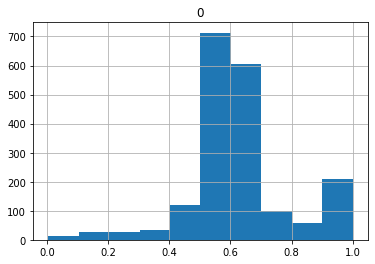

In [397]:
from tensorflow.keras.losses import binary_crossentropy
model = basic_cnn_model((120, 120, 3), n_classes)
y_actual, y_pred, y_pred_probs = get_predictions_for_dataset(train_batch_generator, model)

print('binary_crossentropy - random numbers', 
      binary_crossentropy(np.random.randint(2, size=128), np.random.random_sample(128)).numpy())
print('binary_crossentropy - cnn with initial weights - actual data', 
      binary_crossentropy(np.ravel(y_actual), np.ravel(y_pred_probs)).numpy())

pd.DataFrame(y_pred_probs).hist()

In [439]:
train_batch_generator = get_image_dataset(x, y, augmentations=None, band_stats=stats, 
                                          batch_size=batch_size)

for x, y in train_batch_generator.make_one_shot_iterator():
    print(x.shape, y)

InvalidArgumentError: ValueError: `generator` yielded an element of shape (1, 120, 120, 3) where an element of shape (1,) was expected.
Traceback (most recent call last):

  File "/app/env/lib/python3.6/site-packages/tensorflow_core/python/ops/script_ops.py", line 221, in __call__
    ret = func(*args)

  File "/app/env/lib/python3.6/site-packages/tensorflow_core/python/data/ops/dataset_ops.py", line 621, in generator_py_func
    "of shape %s was expected." % (ret_array.shape, expected_shape))

ValueError: `generator` yielded an element of shape (1, 120, 120, 3) where an element of shape (1,) was expected.


	 [[{{node PyFunc}}]] [Op:IteratorGetNextSync]

In [437]:
# Confirm that the model can overfit on a subset of the data
def validate_can_overfit(model, train_generator):
    n_epochs = 100
    metrics = [Accuracy()]
    loss = 'binary_crossentropy'
    metric_to_monitor = 'accuracy'
    callbacks = [EarlyStopping(monitor=metric_to_monitor, patience=early_stopping_patience, verbose=1)]

    optimizer = Adam(lr=3e-4)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    history = model.fit_generator(train_generator,
                        epochs=n_epochs,
                        callbacks=callbacks,
                        shuffle=True, verbose=1)

    assert history.history['loss'][-1] <= 1e-14
    assert history.history['accuracy'][-1] == 1


# Include both positive and negative class    
x = np.concatenate([x_train[:5], x_train[-5:]])
y = np.concatenate([y_train[:5], y_train[-5:]])
train_batch_generator = get_image_dataset(x, y, augmentations=None, band_stats=stats, 
                                          batch_size=batch_size)

# train_generator = AugmentedImageSequenceFromNpy(x=x_train[:10], y=y_train[:10], batch_size=batch_size, 
#                                                 augmentations=None, band_stats=stats)
validate_can_overfit(model, train_batch_generator)

Epoch 1/100
1/1 [==============================] - 0s 313ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 2/100
1/1 [==============================] - 0s 266ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 3/100
1/1 [==============================] - 0s 346ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 4/100
1/1 [==============================] - 0s 326ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 5/100
1/1 [==============================] - 0s 280ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 6/100
1/1 [==============================] - 0s 320ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 7/100
1/1 [==============================] - 0s 337ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 00007: early stopping


AssertionError: 

In [236]:
def train_keras_model(*, bucket, model_dir, gcs_model_dir, gcs_log_dir, experiment_name, start_model,
                     n_epochs=100):
    model, model_base_metadata = get_model_and_metadata_from_gcs(bucket, model_dir, "h5", load_model, gcs_model_dir, experiment_name)

    model_and_metadata_filepath = os.path.join(model_dir, experiment_name)
    gcs_model_and_metadata_filepath = os.path.join(gcs_model_dir, experiment_name)
    gcs_log_dir = os.path.join(gcs_log_dir, experiment_name)

    if model is not None:
        print('Resuming training at epoch', int(model_base_metadata['epoch']) + 1)
    else:
        now = datetime.datetime.utcnow().strftime("%Y-%m-%d %H:%M")
        model = start_model
        model_base_metadata = {
            'data': 'train_valid_google_automl_cloud_and_shadow_dataset_small.csv',
            'data_prep': 'normalization_augmentation',
            'experiment_name': experiment_name,
            'experiment_start_time': now,
            'model': 'keras_cnn',
            'random_state': random_seed,
            # so that initial_epoch is 0
            'epoch': -1
        }        

    print(f'len(train): {len(x_train)}')
    print(f'len(valid): {len(x_valid)}')

    histories = []
    metrics = ['accuracy']
    loss = 'binary_crossentropy'
    metric_to_monitor = 'val_accuracy'

    optimizer = Adam()
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    verbosity = 0
    # Generators
    train_generator = AugmentedImageSequenceFromNpy(x=x_train, y=y_train, batch_size=batch_size,
                                                    augmentations=None, band_stats=stats)

    valid_generator = AugmentedImageSequenceFromNpy(x=x_valid, y=y_valid, batch_size=batch_size,
                                                    augmentations=None, band_stats=stats)

    callbacks = [
#         EarlyStopping(monitor=metric_to_monitor, patience=early_stopping_patience, verbose=verbosity),
#         ReduceLROnPlateau(monitor=metric_to_monitor, factor=0.5, patience=early_stopping_patience, min_lr=1e-6),
        TensorBoard(gcs_log_dir, histogram_freq=1),
        ModelCheckpointGCS(filepath=model_and_metadata_filepath, gcs_filepath=gcs_model_and_metadata_filepath, 
                           gcs_bucket=bucket, model_metadata=model_base_metadata, monitor=metric_to_monitor, 
                           verbose=verbosity)
    ]

    history = model.fit(train_generator, initial_epoch=int(model_base_metadata['epoch']) + 1,
                                  epochs=n_epochs,
                                  steps_per_epoch=len(train_generator),
                                  callbacks=callbacks,
                                  validation_data=valid_generator, validation_steps=len(valid_generator),
                                  shuffle=True, verbose=1)

    actual_y_train, pred_y_train, pred_y_train_probs = train_generator.get_predictions(model)
    actual_y_valid, pred_y_valid, pred_y_valid_probs = valid_generator.get_predictions(model)

    metadata_filepath = f"{model_and_metadata_filepath}_metadata.json"
    with open(metadata_filepath, 'r') as json_file:
        best_model_metadata = json.load(json_file)

    best_model_metadata.update({
        'accuracy_train': sklearn.metrics.accuracy_score(actual_y_train, pred_y_train),
        'accuracy_valid': sklearn.metrics.accuracy_score(actual_y_valid, pred_y_valid),
        'f1_score_train': sklearn.metrics.f1_score(actual_y_train, pred_y_train),
        'f1_score_valid': sklearn.metrics.f1_score(actual_y_valid, pred_y_valid),
        'confusion_matrix': numpy_to_json(sklearn.metrics.confusion_matrix(actual_y_valid, pred_y_valid)),
        'precision_recall_curve': sklearn_precision_recall_curve_to_dict(
            sklearn.metrics.precision_recall_curve(actual_y_valid, pred_y_valid)),
    })

    with open(metadata_filepath, 'w+') as json_file:
        json.dump(best_model_metadata, json_file)

    blob = bucket.blob(f"{gcs_model_and_metadata_filepath}_metadata.json")
    blob.upload_from_filename(metadata_filepath)

    # Attempt to avoid memory leaks
    del train_generator
    del valid_generator
    gc.collect()
    return history

# if os.environ.get("SHOULD_PREDICT", "True") == "True":
#     pred_test_labels = predict(model=model, weight_dir=model_path, x=x_test, batch_size=batch_size, n_classes=n_classes)
#     clf_report = classification_report(y_test_labels, pred_test_labels, target_names=classes)
#     print(clf_report)

In [238]:
experiment_name = f"{project_name}_basic_cnn_2020_1_31"
history = train_keras_model(bucket=bucket, model_dir=model_dir, gcs_model_dir=gcs_model_dir, gcs_log_dir=gcs_log_dir, 
                  experiment_name=experiment_name, start_model=basic_cnn_model((120, 120, 3), n_classes=n_classes),
                            n_epochs=3)
logger.info(f"Finished training for experiment {experiment_name}")

len(train): 256
len(valid): 256
Train for 2 steps, validate for 2 steps
Epoch 1/3
2/2 [==============================] - 30s 15s/step - loss: 47.7670 - accuracy: 0.5000 - val_loss: 7.8142 - val_accuracy: 0.5469
Epoch 2/3
2/2 [==============================] - 10s 5s/step - loss: 10.6520 - accuracy: 0.0469 - val_loss: 0.6800 - val_accuracy: 0.5469
Epoch 3/3
2/2 [==============================] - 11s 6s/step - loss: 0.7885 - accuracy: 0.5000 - val_loss: 0.6864 - val_accuracy: 0.5469
Finished training for experiment cloud_and_shadow_basic_cnn_2020_1_31


In [239]:
history

In [30]:
# experiment_name = f"{project_name}_basic_cnn_best_practices_2020_1_31"
# train_keras_model(bucket=bucket, model_dir=model_dir, gcs_model_dir=gcs_model_dir, gcs_log_dir=gcs_log_dir, 
#                   experiment_name=experiment_name, start_model=basic_cnn_model_with_best_practices((120, 120, 3), n_classes=n_classes))
# logger.info(f"Finished training for experiment {experiment_name}")

Loading previously trained model.
Resuming training at epoch 1
len(train): 100
len(valid): 100
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1 steps, validate for 1 steps
Epoch 2/3
1/1 [==============================] - 20s 20s/step - loss: 1.4209 - accuracy: 0.0400 - val_loss: 5.7233 - val_accuracy: 0.0100
Epoch 3/3
1/1 [==============================] - 12s 12s/step - loss: 0.6108 - accuracy: 0.0300 - val_loss: 8.5210 - val_accuracy: 0.0000e+00
Finished training for experiment cloud_and_shadow_basic_cnn_best_practices_2020_1_31
Finished training for experiment cloud_and_shadow_basic_cnn_best_practices_2020_1_31


In [31]:
# from sklearn.metrics import classification_report

# test_generator = AugmentedImageSequenceFromNpy(x=x_test, y=None, batch_size=batch_size,
#                                                         augmentations=AUGMENTATIONS_TEST)
# y_pred = model.predict(test_generator)
# y_pred_binary = [0 if pred < .5 else 1 for pred in y_pred]
# clf = classification_report(y_test, y_pred_binary,  target_names=['has_clouds'])

In [32]:
# print(pd.DataFrame(y_pred)[0].unique())
# print(pd.DataFrame(y_pred_binary)[0].unique())
# pd.DataFrame(y_pred)[0].unique()
# pd.DataFrame(y_pred_binary)[0].unique()
# full_histories = join_histories(histories)
# graph_model_history(full_histories)